In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import argparse
import numpy as np
import torch
import cPickle as cp
import sys, os
sys.path.append("../../utils")
sys.path.append("../")

from data_loader import load_census_data
from rff import GaussianKernel, RFF
from kernel_regressor import Quantizer, KernelRidgeRegression

In [2]:
class Args(object):
    def __init__(self, n_fp_rff, n_bit, 
                 exact_kernel, reg_lambda, 
                 sigma, random_seed, data_path,
                 do_fp, test_var_reduce=False):
        self.n_fp_rff = n_fp_rff
        self.n_bit = n_bit
        self.exact_kernel = exact_kernel
        self.reg_lambda = reg_lambda
        self.sigma = sigma
        self.random_seed = random_seed
        self.data_path = data_path
        self.do_fp = do_fp
        self.test_var_reduce = test_var_reduce

In [3]:
def load_census_data(path):
    X_test = np.load(path + "X_ho.npy")
    X_train = np.load(path + "X_tr.npy")
    Y_test = np.load(path + "Y_ho.npy")
    Y_train = np.load(path + "Y_tr.npy")
    X_test = X_test.item()['X_ho']
    X_train = X_train.item()['X_tr']
    Y_test = Y_test.item()['Y_ho']
    Y_train = Y_train.item()['Y_tr']
    s = np.arange(X_train.shape[0] )
    np.random.shuffle(s)
    X_train = X_train[s, :]
    Y_train = Y_train[s]
#     # DEBUG
#     X_train, Y_train, X_test, Y_test = \
#       X_train[::3, :], Y_train[::3], X_test[::3, :], Y_test[::3]
    X_train, Y_train, X_test, Y_test = \
      X_train[::3, :], Y_train[::3], X_test[::3, :], Y_test[::3]
    return X_train, X_test, Y_train, Y_test

In [4]:
data_path = "../../../data/census/"

In [5]:
class QuantizerIndependentQuant(object):
    def __init__(self, nbit, min_val, max_val, scale=None, rand_seed=1):
        self.nbit = nbit
        self.min_val = min_val
        self.max_val = max_val
        if scale == None:
            self.scale = (max_val - min_val) / float(2**self.nbit - 1)
        self.rand_seed = rand_seed

    def quantize_random(self, value):
        value = torch.clamp(value, self.min_val, self.max_val)
        floor_val = self.min_val + torch.floor( (value - self.min_val) / self.scale) * self.scale
        ceil_val = self.min_val + torch.ceil( (value - self.min_val) / self.scale) * self.scale
        # print("test in the middle ", torch.min(floor_val), torch.max(ceil_val), self.min_val, self.max_val)
        # exit(0)
        floor_prob = (ceil_val - value) / self.scale
        ceil_prob = (value - floor_val) / self.scale
        
#         print("test f prob ", floor_prob.size(), self.max_val, self.min_val, self.scale)
        
        # sanity check
        # np.testing.assert_array_almost_equal(floor_prob.cpu().numpy(), 
        #   1 - ceil_prob.cpu().numpy(), decimal=6)
        print(" test quantizer using random seed", self.rand_seed)
        self.rand_seed += 1
        np.random.seed(self.rand_seed)
        sample = torch.DoubleTensor(np.random.uniform(size=list(value.size() ) ) )
           
#         print("test sample ", sample[:20])
#         raw_input()
    
        # quant_val = floor_val * (sample < floor_prob).float() \
        #   + ceil_val * (sample >= floor_prob).float()
        quant_val = floor_val * (sample < floor_prob).double() \
          + ceil_val * (sample >= floor_prob).double()
            
#         print("test quant ", quant_val[:20])
#         raw_input()
            
        return quant_val

    def quantize(self, value):
        # TODO update if we have other quantization schemes
        return self.quantize_random(value)

In [6]:
class KernelRidgeRegressionIndependentQuant(object):
    def __init__(self, kernel, reg_lambda):
        '''
        reg_lambda is the strength of the regression regularizor
        kernel matrix is a Pytorch Tensor
        '''
        # self.kernel_mat = kernel_mat
        self.reg_lambda = reg_lambda
        self.kernel = kernel

    def fit(self, X_train=None, Y_train=None, kernel_mat=None, quantizer=None):
        self.X_train, self.Y_train = X_train, Y_train
        self.kernel_mat = self.kernel.get_kernel_matrix(X_train, X_train, quantizer, quantizer)
        n_sample = self.kernel_mat.size(0)
        
#         # Sanity check
#         print torch.sum(self.kernel.rff_x1)
#         print torch.sum(self.kernel.rff_x2)
#         print self.kernel.rff_x1
#         print self.kernel.rff_x2
#         raw_input()
        
        # # DEBUG
        # print("start timing ", self.kernel_mat.size() )
        # test = (self.kernel_mat + self.reg_lambda * torch.eye(n_sample) )
        # test = test.cpu().numpy()
        # start_time = time()
        # np.linalg.inv(test)
        # end_time = time()
        # print("numpy inverse time ", end_time - start_time)

        # # test = (self.kernel_mat + self.reg_lambda * torch.eye(n_sample) )[0:5000, 0:5000]
        # # start_time = time()
        # # torch.inverse(test)
        # # end_time = time()
        # # print("pytorch inverse time ", end_time - start_time)
        # exit(0)

        # pytorch is super slow in inverse, so we finish this operation in numpy
        print("using regularior strength ", self.reg_lambda)
#         self.alpha = torch.DoubleTensor( \
#           np.dot(np.linalg.inv( (self.kernel_mat + self.reg_lambda * torch.eye(n_sample).double() ).cpu().numpy() ), Y_train) )
        # self.alpha = torch.mm(torch.inverse(self.kernel_mat + self.reg_lambda * torch.eye(n_sample) ), 
        #   torch.DoubleTensor(Y_train) )

    def get_train_error(self):
        prediction = torch.mm(self.kernel_mat, self.alpha)
        error = prediction - torch.DoubleTensor(self.Y_train)
        return torch.mean(error**2)

    def predict(self, X_test, quantizer_train=None, quantizer_test=None):
        # quantizer 1 for test data, quantizer 2 for train data
        self.X_test = X_test
        self.kernel_mat_pred = \
          self.kernel.get_kernel_matrix(self.X_test, self.X_train, quantizer_test, quantizer_train)
        self.prediction = torch.mm(self.kernel_mat_pred, self.alpha)
        return self.prediction.clone()

    def get_test_error(self, Y_test):
        # should only be called right after the predict function
        self.Y_test = Y_test
        error = self.prediction - torch.DoubleTensor(self.Y_test)
        return torch.mean(error**2)


In [7]:
def get_spectrum(args):
    X_train, X_test, Y_train, Y_test = load_census_data(args.data_path)
    kernel = GaussianKernel(sigma=args.sigma)
    kernel_mat_exact_train = kernel.get_kernel_matrix(X_train, X_train)
    kernel_mat_exact_test = kernel.get_kernel_matrix(X_test, X_train)
    n_input_feat = X_train.shape[1]
    assert X_train.shape[1] == X_test.shape[1]
    if args.exact_kernel:
        print "exact kernel"
        kernel = kernel
        quantizer_train = None
        quantizer_test = None
        config_name = "exact_kernel_lambda_" + str(args.reg_lambda) + "_sigma_" + str(args.sigma)
    elif args.do_fp:
        print "full precision rff"
        kernel = RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        quantizer_train = None
        quantizer_test = None
        config_name = "fp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff)
    else:
        print "low precsion rff with nbit = ", args.n_bit
        n_quantized_rff = int(np.floor(args.n_fp_rff / float(args.n_bit) * 32.0) )
        min_val = -np.sqrt(2.0/float(n_quantized_rff) )
        max_val = np.sqrt(2.0/float(n_quantized_rff) )
        quantizer_train = QuantizerIndependentQuant(args.n_bit, min_val, max_val, rand_seed=args.random_seed)
        if not args.test_var_reduce:
            quantizer_test = quantizer_train
        else:
            quantizer_test = None
        kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=args.random_seed)
        config_name = "lp_rff_lambda_" + str(args.reg_lambda) + "_sigma_" \
          + str(args.sigma) + "_n_fp_rff_" + str(args.n_fp_rff) + "_nbit_" + str(args.n_bit) 

#     regressor = KernelRidgeRegression(kernel, reg_lambda=args.reg_lambda)
    regressor = KernelRidgeRegressionIndependentQuant(kernel, reg_lambda=args.reg_lambda)
    print("start to do regression!")
    # print("test quantizer", quantizer)
    regressor.fit(X_train, Y_train, quantizer=quantizer_train)
    print("finish regression!")
    
    kernel_mat = regressor.kernel_mat
    _, s, _ = np.linalg.svd(kernel_mat.cpu().numpy().astype(np.float64), full_matrices=True)
    return s, kernel_mat.cpu().numpy().astype(np.float64)

In [8]:
# args = Args(n_fp_rff=1024, n_bit=1, 
#             exact_kernel=False, reg_lambda=1e-3, 
#             sigma=30.0, random_seed=1, 
#             data_path=data_path, do_fp=False)
# s_8 = get_spectrum(args)
# # with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd.npy", "wb") as f:
# #     np.save(f, s_8)
# # print s_fp

### exact kernel

In [9]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=True, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_exact, k_exact = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_ind.npy", "wb") as f:
    np.save(f, s_exact)
# print s_exact

('using sigma ', 30.0)
('using sigma ', 30.0)
exact kernel
start to do regression!
('using sigma ', 30.0)
('using regularior strength ', 0.001)
finish regression!


### 1024 feature full precision

In [10]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=True)
s_fp, k_fp = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd_ind.npy", "wb") as f:
    np.save(f, s_fp)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd_ind.npy", "rb") as f:
    test = np.load(f)
print np.sum(s_fp - test)

('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 1024)
start to do regression!
('using regularior strength ', 0.001)
finish regression!
0.0


### 1024 feature 8 --> 1 bit

In [11]:
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_8, k_8 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd_ind.npy", "wb") as f:
    np.save(f, s_8)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  8
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 4096)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 8)
('quantizer 1 scale', 0.00017331048558493812)
(' test quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 8)
('quantizer 2 scale', 0.00017331048558493812)
(' test quantizer using random seed', 2)
('using regularior strength ', 0.001)
finish regression!


In [12]:
args = Args(n_fp_rff=1024, n_bit=4, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_4, k_4 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_ind.npy", "wb") as f:
    np.save(f, s_4)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  4
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 4)
('quantizer 1 scale', 0.0020833333333333333)
(' test quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 4)
('quantizer 2 scale', 0.0020833333333333333)
(' test quantizer using random seed', 2)
('using regularior strength ', 0.001)
finish regression!


In [13]:
args = Args(n_fp_rff=1024, n_bit=2, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_2, k_2 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_ind.npy", "wb") as f:
    np.save(f, s_2)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  2
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 16384)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 2)
('quantizer 1 scale', 0.0073656956373598708)
(' test quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 2)
('quantizer 2 scale', 0.0073656956373598708)
(' test quantizer using random seed', 2)
('using regularior strength ', 0.001)
finish regression!


In [14]:
args = Args(n_fp_rff=1024, n_bit=1, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_1, k_1 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd_ind.npy", "wb") as f:
    np.save(f, s_1)
# # print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  1
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 32768)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 1)
('quantizer 1 scale', 0.015625)
(' test quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 1)
('quantizer 2 scale', 0.015625)
(' test quantizer using random seed', 2)
('using regularior strength ', 0.001)
finish regression!


[  4.86647875e+03   1.02861342e+02   7.78494278e+01 ...,   1.69865660e-07
   1.50478971e-07   1.45085974e-07]


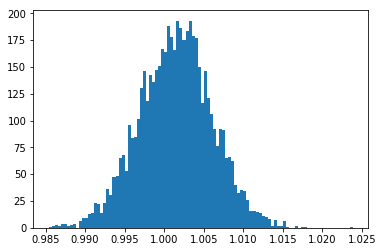

In [15]:
print s_exact
plt.figure()
_ = plt.hist(np.diag(k_2),bins=100)
plt.show()

In [ ]:
# args = Args(n_fp_rff=1024, n_bit=2, 
#             exact_kernel=False, reg_lambda=1e-3, 
#             sigma=30.0, random_seed=1, 
#             data_path=data_path, do_fp=False)
# s_2, kernel_2 = get_spectrum(args)
# # with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd_ind.npy", "wb") as f:
# #     np.save(f, s_1)
# # print s_fp

[  4.86647875e+03   1.02861342e+02   7.78494278e+01 ...,   1.69865660e-07
   1.50478971e-07   1.45085974e-07]


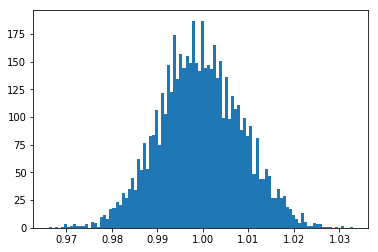

In [16]:
print s_exact
plt.figure()
_ = plt.hist(np.diag(k_1),bins=100)
plt.show()

In [17]:
args = Args(n_fp_rff=1024, n_bit=16, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_16, k_16 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd_ind.npy", "wb") as f:
    np.save(f, s_16)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  16
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 2048)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 16)
('quantizer 1 scale', 9.5368886854352636e-07)
(' test quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 16)
('quantizer 2 scale', 9.5368886854352636e-07)
(' test quantizer using random seed', 2)
('using regularior strength ', 0.001)
finish regression!


In [18]:
args = Args(n_fp_rff=1024, n_bit=32, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)
s_32, k_32 = get_spectrum(args)
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd_ind.npy", "wb") as f:
    np.save(f, s_32)
# print s_fp

('using sigma ', 30.0)
('using sigma ', 30.0)
low precsion rff with nbit =  32
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 1024)
start to do regression!
('quantization 1 activated ', (5456, 119))
('quantizer 1 bits', 32)
('quantizer 1 scale', 2.0579515879251518e-11)
(' test quantizer using random seed', 1)
('quantization 2 activated ', (5456, 119))
('quantizer 2 bits', 32)
('quantizer 2 scale', 2.0579515879251518e-11)
(' test quantizer using random seed', 2)
('using regularior strength ', 0.001)
finish regression!


### spectrum comparison of x1x1 and x1x2

In [19]:
# with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_32 = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_16 = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_1 = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_32_old = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_16_old = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_8_old = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_4_old = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_2_old = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_1_old = np.load(f)

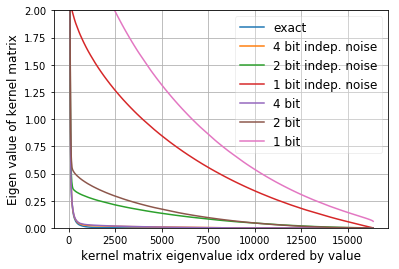

In [20]:
plt.figure()
plt.plot(s_exact, label="exact")
# plt.plot(s_fp, label="fp")
plt.plot(s_4, label="4 bit indep. noise")
plt.plot(s_2, label="2 bit indep. noise")
plt.plot(s_1, label="1 bit indep. noise")
plt.plot(s_4_old, label="4 bit")
plt.plot(s_2_old, label="2 bit")
plt.plot(s_1_old, label="1 bit")
plt.ylim([1e-3, 2])
plt.grid()
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Eigen value of kernel matrix", fontsize=12)
plt.xlabel("kernel matrix eigenvalue idx ordered by value", fontsize=12)
plt.savefig("../../notes/figures/spectrum_1024_indep.pdf")
plt.show()

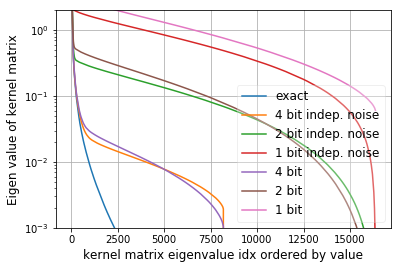

In [23]:
plt.figure()
plt.plot(s_exact, label="exact")
# plt.plot(s_fp, label="fp")
plt.plot(s_4, label="4 bit indep. noise")
plt.plot(s_2, label="2 bit indep. noise")
plt.plot(s_1, label="1 bit indep. noise")
plt.plot(s_4_old, label="4 bit")
plt.plot(s_2_old, label="2 bit")
plt.plot(s_1_old, label="1 bit")
plt.ylim([1e-3, 2])
plt.grid()
# plt.title("1024 features")
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Eigen value of kernel matrix", fontsize=12)
plt.xlabel("kernel matrix eigenvalue idx ordered by value", fontsize=12)
ax=plt.subplot(111)
ax.set_yscale("log")
plt.savefig("../../notes/figures/spectrum_1024_indep_log.pdf")
plt.show()

In [24]:
# with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_32 = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_16 = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_4_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_2_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_1_bit_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_1 = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd_ind_full_dataset.npy", "rb") as f:
#     s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_ind_full_dataset.npy", "rb") as f:
    s_exact = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_32_old = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_16_old = np.load(f)
# with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd_full_dataset.npy", "rb") as f:
#     s_8_old = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_4_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_4_old = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_2_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_2_old = np.load(f)
with open("../multi_seed_results/spectrum/s_8192_feat_1_bit_64b_svd_full_dataset.npy", "rb") as f:
    s_1_old = np.load(f)

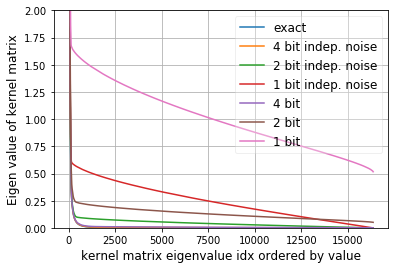

In [29]:
plt.figure()
plt.plot(s_exact, label="exact")
# plt.plot(s_fp, label="fp")
plt.plot(s_4, label="4 bit indep. noise")
plt.plot(s_2, label="2 bit indep. noise")
plt.plot(s_1, label="1 bit indep. noise")
plt.plot(s_4_old, label="4 bit")
plt.plot(s_2_old, label="2 bit")
plt.plot(s_1_old, label="1 bit")
plt.ylim([1e-3, 2])
plt.grid()
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Eigen value of kernel matrix", fontsize=12)
plt.xlabel("kernel matrix eigenvalue idx ordered by value", fontsize=12)
plt.savefig("../../notes/figures/spectrum_8192_indep.pdf")
plt.show()

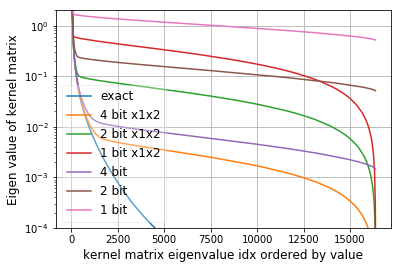

In [30]:
plt.figure()
plt.plot(s_exact, label="exact")
# plt.plot(s_fp, label="fp")
plt.plot(s_4, label="4 bit x1x2")
plt.plot(s_2, label="2 bit x1x2")
plt.plot(s_1, label="1 bit x1x2")
plt.plot(s_4_old, label="4 bit")
plt.plot(s_2_old, label="2 bit")
plt.plot(s_1_old, label="1 bit")
plt.ylim([1e-4, 2])
plt.grid()
plt.legend(framealpha=0.3, fontsize=12)
plt.ylabel("Eigen value of kernel matrix", fontsize=12)
plt.xlabel("kernel matrix eigenvalue idx ordered by value", fontsize=12)
ax=plt.subplot(111)
ax.set_yscale("log")
plt.savefig("../../notes/figures/spectrum_8192_indep_log.pdf")
plt.show()

In [6]:
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd_ind.npy", "rb") as f:
    s_32 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd_ind.npy", "rb") as f:
    s_16 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd_ind.npy", "rb") as f:
    s_8 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd_ind.npy", "rb") as f:
    s_4 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd_ind.npy", "rb") as f:
    s_2 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd_ind.npy", "rb") as f:
    s_1 = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_fp_64b_svd_ind.npy", "rb") as f:
    s_fp = np.load(f)
with open("../multi_seed_results/spectrum/s_exact_64b_svd_ind.npy", "rb") as f:
    s_exact = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_32_bit_64b_svd.npy", "rb") as f:
    s_32_old = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_16_bit_64b_svd.npy", "rb") as f:
    s_16_old = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_8_bit_64b_svd.npy", "rb") as f:
    s_8_old = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_4_bit_64b_svd.npy", "rb") as f:
    s_4_old = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_2_bit_64b_svd.npy", "rb") as f:
    s_2_old = np.load(f)
with open("../multi_seed_results/spectrum/s_1024_feat_1_bit_64b_svd.npy", "rb") as f:
    s_1_old = np.load(f)

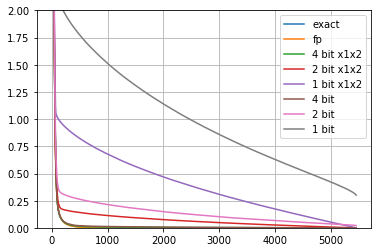

In [12]:
plt.figure()
plt.plot(s_exact, label="exact")
plt.plot(s_fp, label="fp")
plt.plot(s_4, label="4 bit x1x2")
plt.plot(s_2, label="2 bit x1x2")
plt.plot(s_1, label="1 bit x1x2")
plt.plot(s_4_old, label="4 bit")
plt.plot(s_2_old, label="2 bit")
plt.plot(s_1_old, label="1 bit")
# plt.semilogy(s_exact, label="exact")
# plt.semilogy(s_fp, label="fp")
# plt.semilogy(s_4, label="4 bit x1x2")
# plt.semilogy(s_2, label="2 bit x1x2")
# plt.semilogy(s_1, label="1 bit x1x2")
# plt.semilogy(s_4_old, label="4 bit")
# plt.semilogy(s_2_old, label="2 bit")
# plt.semilogy(s_1_old, label="1 bit")
# plt.semilogy(s_fp_8192, label="fp 8192")
plt.grid()
plt.ylim([1e-3, 2])
plt.legend()
plt.show()

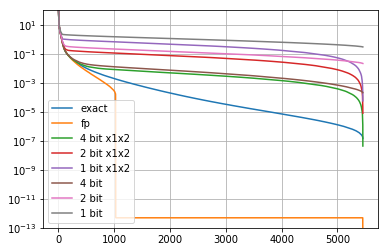

In [7]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
# plt.semilogy(s_32, label="32 bit")
# plt.semilogy(s_16, label="16 bit")
# plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit x1x2")
plt.semilogy(s_2, label="2 bit x1x2")
plt.semilogy(s_1, label="1 bit x1x2")
plt.semilogy(s_4_old, label="4 bit")
plt.semilogy(s_2_old, label="2 bit")
plt.semilogy(s_1_old, label="1 bit")
# plt.semilogy(s_fp_8192, label="fp 8192")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

In [19]:
args = Args(n_fp_rff=8192, n_bit=8, 
            exact_kernel=False, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=True)
s_fp_8192, k_fp_8192 = get_spectrum(args)

('using sigma ', 30.0)
('using sigma ', 30.0)
full precision rff
('using sigma ', 0.03333333333333333, 'using rand seed ', 1)
('using n rff features ', 8192)
start to do regression!
('using regularior strength ', 0.001)
finish regression!


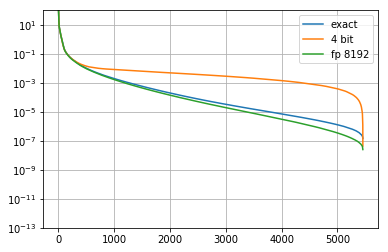

In [22]:
plt.figure()
plt.semilogy(s_exact, label="exact")
# plt.semilogy(s_fp, label="fp")
# plt.semilogy(s_32, label="32 bit")
# plt.semilogy(s_16, label="16 bit")
# plt.semilogy(s_8, label="8 bit")
plt.semilogy(s_4, label="4 bit")
# plt.semilogy(s_2, label="2 bit")
# plt.semilogy(s_1, label="1 bit")
plt.semilogy(s_fp_8192, label="fp 8192")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

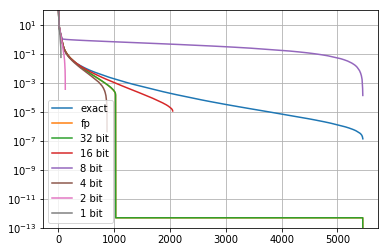

In [69]:
plt.figure()
plt.semilogy(s_exact, label="exact")
plt.semilogy(s_fp, label="fp")
plt.semilogy(s_32 - 2.0 * (1/ float(2**32 - 1) )**2, label="32 bit")
plt.semilogy(s_16 - 2.0 * (1/ float(2**16 - 1) )**2, label="16 bit")
plt.semilogy(s_8 - 2.0 * (1/ float(2**8 - 1) )**2, label="8 bit")
plt.semilogy(s_4 - 2.0 * (1/ float(2**4 - 1) )**2, label="4 bit")
plt.semilogy(s_2 - 2.0 * (1/ float(2**2 - 1) )**2, label="2 bit")
plt.semilogy(s_1 - 2.0 * (1/ float(2**1 - 1) )**2, label="1 bit")
plt.grid()
plt.ylim([1e-13, 1e2])
plt.legend()
plt.show()

[  4.88397570e+03   1.00325907e+02   7.55218562e+01 ...,   1.50398710e-07
   1.46689077e-07   1.37790439e-07]


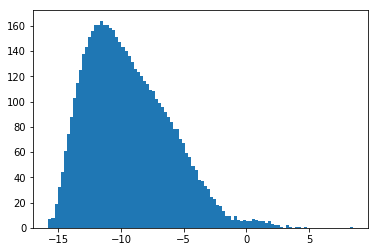

In [47]:
print s_exact
plt.figure()
_ = plt.hist(np.log(s_exact),bins=100)
plt.show()

[  4.90969832e+03   9.70143982e+01   7.76616874e+01 ...,   4.90506827e-13
   1.17740806e-13   2.70999090e-14]


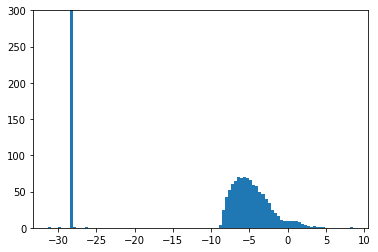

In [57]:
print s_fp
plt.figure()
_ = plt.hist(np.log(s_fp),bins=100)
plt.ylim([0, 300])
plt.show()

[  4.91175306e+03   9.86626953e+01   7.49181222e+01 ...,   4.90672608e-13
   1.19232062e-13   2.74631914e-14]


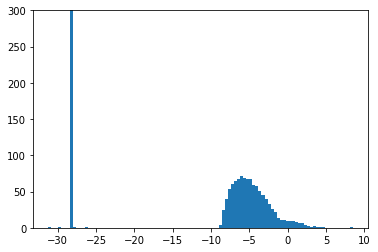

In [58]:
print s_32
plt.figure()
_ = plt.hist(np.log(s_32),bins=100)
plt.ylim([0, 300])
plt.show()

[  4.93274184e+03   9.88125823e+01   7.48778165e+01 ...,   7.08205909e-14
   4.38004409e-14   3.44924484e-14]


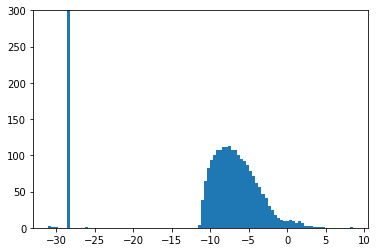

In [59]:
print s_16
plt.figure()
_ = plt.hist(np.log(s_16),bins=100)
plt.ylim([0, 300])
plt.show()

[  4.87945227e+03   9.70093789e+01   7.63480257e+01 ...,   2.70609205e-04
   1.65688544e-04   2.61534361e-05]


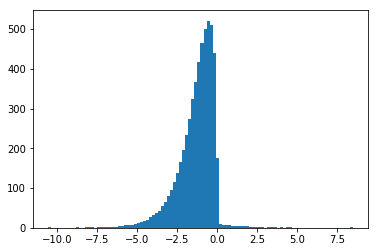

In [61]:
print s_8
plt.figure()
_ = plt.hist(np.log(s_8),bins=100)
# plt.ylim([0, 300])
plt.show()

[  4.86136062e+03   1.00589585e+02   7.70854530e+01 ...,   2.28810898e-06
   1.36175427e-06   4.67959513e-07]


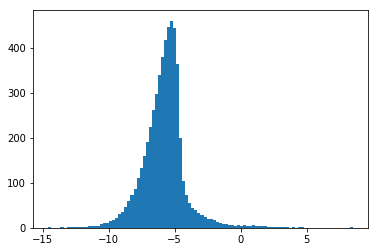

In [62]:
print s_4
plt.figure()
_ = plt.hist(np.log(s_4),bins=100)
plt.show()

[  4.88397819e+03   1.01018953e+02   7.47170578e+01 ...,   3.61711621e-05
   2.16715708e-05   8.06056508e-06]


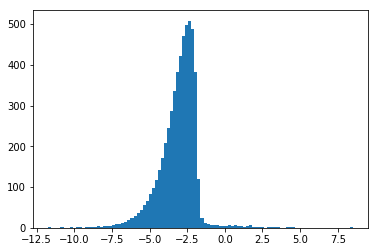

In [63]:
print s_2
plt.figure()
_ = plt.hist(np.log(s_2),bins=100)
plt.show()

[  4.88670006e+03   9.72378925e+01   7.62396480e+01 ...,   2.49561518e-04
   1.63474904e-04   2.22622503e-05]


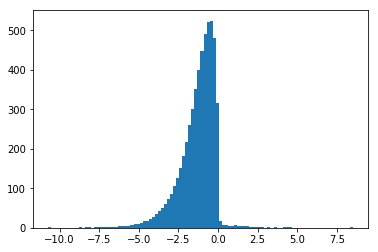

In [64]:
print s_1
plt.figure()
_ = plt.hist(np.log(s_1),bins=100)
plt.show()

# Below are old cold

(array([ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  7.01975496e-03,   1.65006816e+00,   3.29311657e+00,
          4.93616497e+00,   6.57921338e+00,   8.22226178e+00,
          9.86531019e+00,   1.15083586e+01,   1.31514070e+01,
          1.47944554e+01,   1.64375038e+01]),
 <a list of 10 Patch objects>)

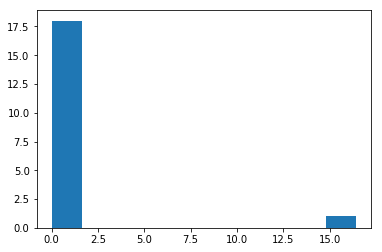

In [56]:
plt.hist(s)